In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/TASK-ML-INTERN.csv")

In [3]:
print("Dataset Info:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
Dataset Info:
 None


In [4]:
print("Dataset Head:\n", df.head())

Dataset Head:
            hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.773013  0.761431  0.763488   

        443      

In [5]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 hsi_id           0
0                0
1                0
2                0
3                0
                ..
444              0
445              0
446              0
447              0
vomitoxin_ppb    0
Length: 450, dtype: int64


In [6]:
X = df.drop(columns=['hsi_id', 'vomitoxin_ppb'])  # Exclude ID & target
y = df['vomitoxin_ppb']

Standardizing the spectral data

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 Line Plot: Mean Reflectance Across Wavelength Bands

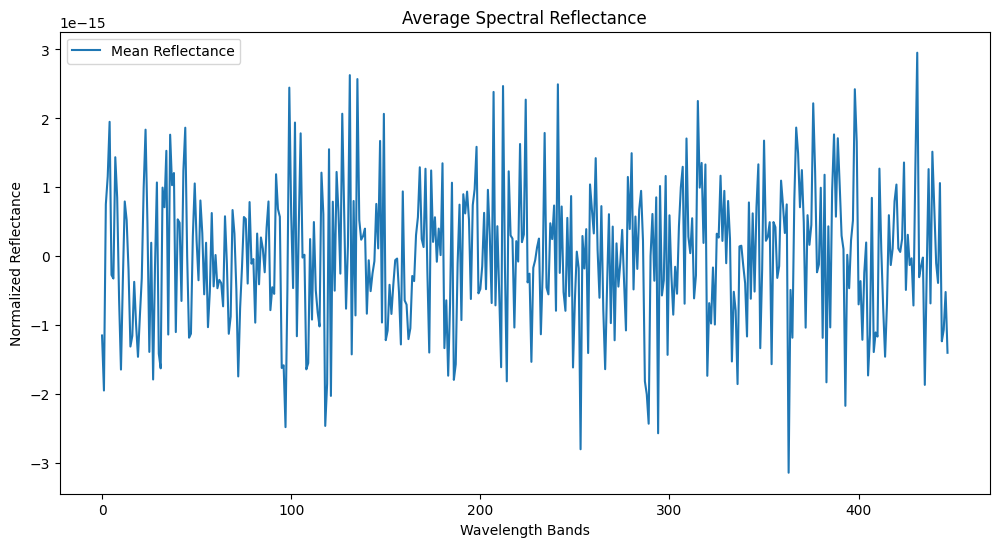

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(X.shape[1]), np.mean(X_scaled, axis=0), label='Mean Reflectance')
plt.xlabel("Wavelength Bands")
plt.ylabel("Normalized Reflectance")
plt.title("Average Spectral Reflectance")
plt.legend()
plt.show()

Heatmap: Spectral Data for First 50 Corn Samples

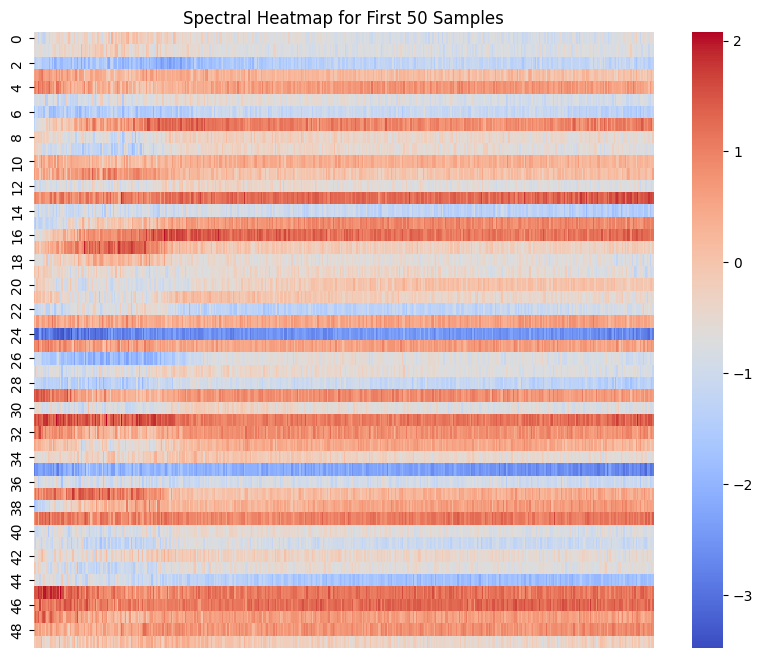

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_scaled[:50], cmap="coolwarm", xticklabels=False)
plt.title("Spectral Heatmap for First 50 Samples")
plt.show()

Feature Engineering: PCA for Dimensionality Reduction

In [10]:
pca = PCA(n_components=20)  # Reduce to 20 principal components
X_pca = pca.fit_transform(X_scaled)

Cumulative Explained Variance Plot

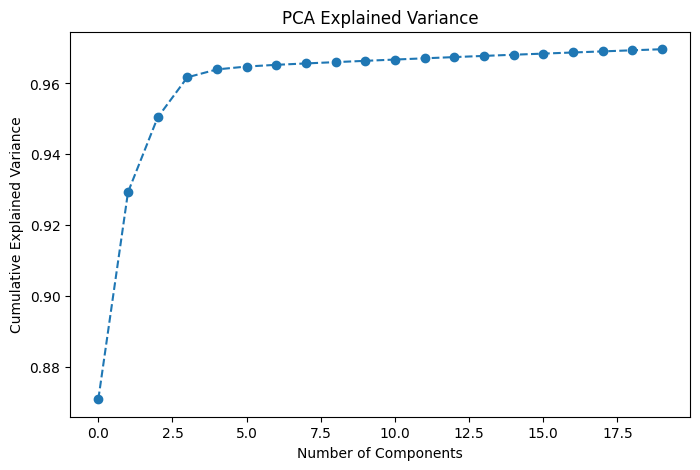

In [11]:
# Variance explained by each component
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

PCA 2D Scatter Plot

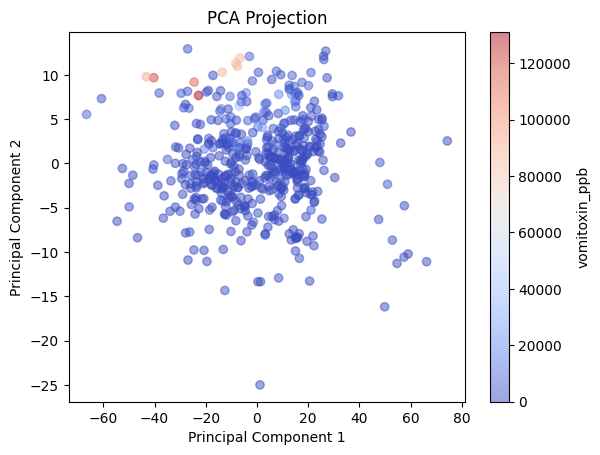

In [12]:
# 2D PCA Scatter Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection")
plt.colorbar(label="vomitoxin_ppb")
plt.show()

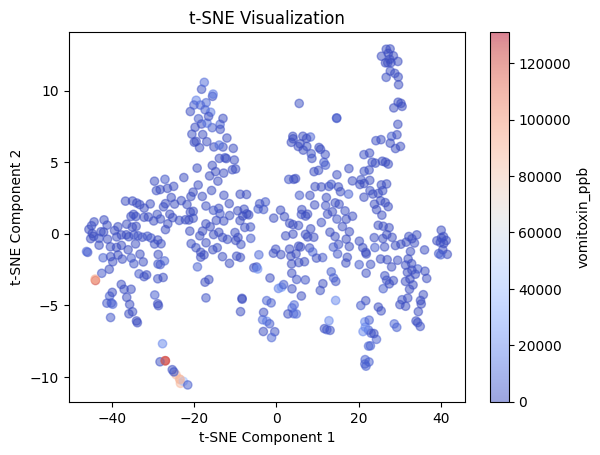

In [13]:
# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.colorbar(label="vomitoxin_ppb")
plt.show()

Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Random Forest and XGBoost models

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

In [17]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Make predictions

In [19]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

Function to evaluate models using MAE, RMSE, and R² score

In [20]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}\n")
    return mae, rmse, r2

Evaluate both models

In [21]:
evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest Performance:
MAE: 2674.7867, RMSE: 7119.3581, R^2: 0.8187



(2674.7867000000006, 7119.358081053586, 0.818678871557292)

In [22]:
evaluate_model(y_test, y_pred_xgb, "XGBoost")

XGBoost Performance:
MAE: 1729.7213, RMSE: 3395.7421, R^2: 0.9587



(1729.7212828445436, 3395.742093044118, 0.9587488428876344)

Scatter plot: Actual vs Predicted DON Concentration

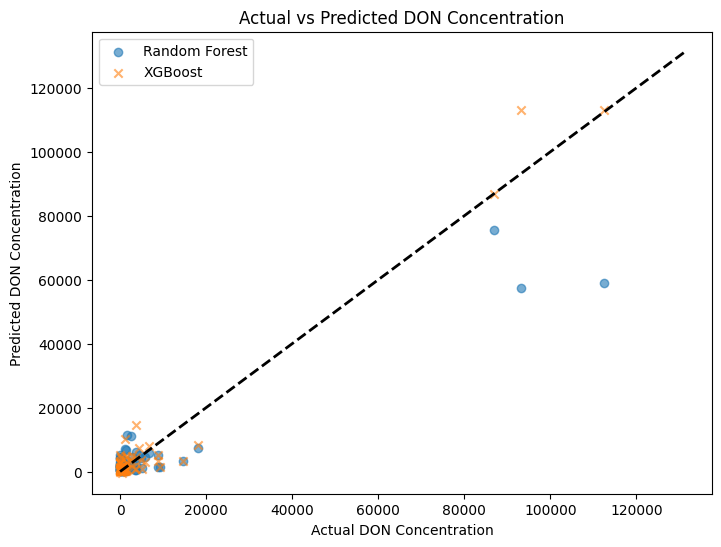

In [23]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Random Forest")
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label="XGBoost", marker='x')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs Predicted DON Concentration")
plt.legend()
plt.show()


SHAP (SHapley Additive exPlanations) for feature importance analysis

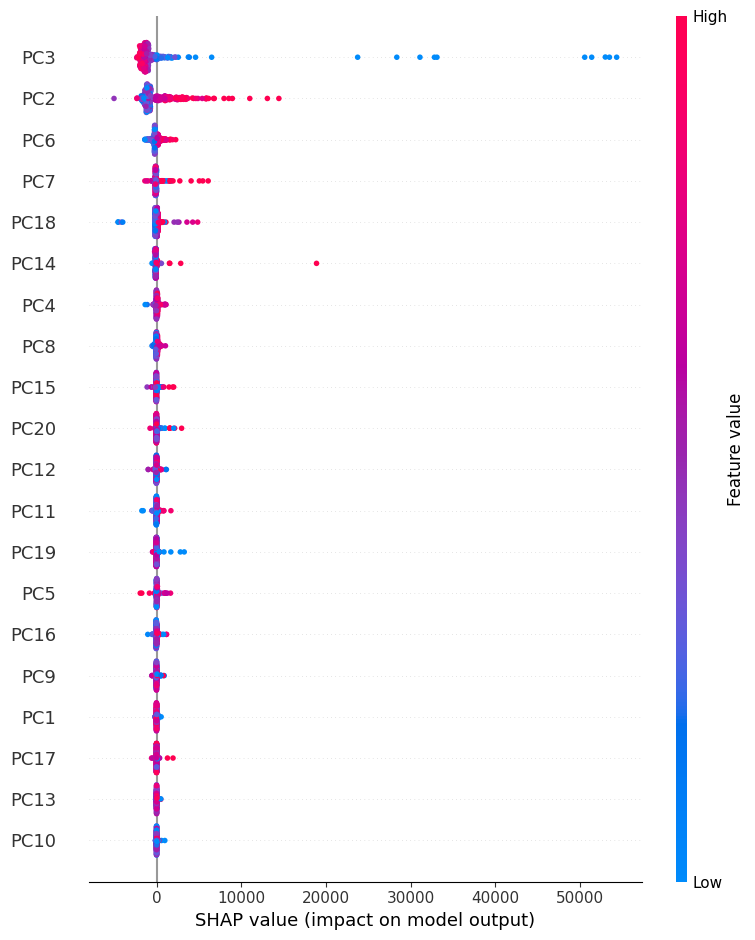

In [24]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=[f'PC{i+1}' for i in range(X_train.shape[1])])
plt.show()

#Hyperparameter tuning for XGBoost using GridSearchCV

In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define XGBoost model
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final model with best params
tuned_xgb = XGBRegressor(**grid_search.best_params_, objective="reg:squarederror", random_state=42)
tuned_xgb.fit(X_train, y_train)

# Predict & Evaluate
y_pred_tunedxgb = tuned_xgb.predict(X_test)
evaluate_model(y_test, y_pred_tunedxgb, "Tuned XGBoost")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}
Tuned XGBoost Performance:
MAE: 1738.6320, RMSE: 3422.2255, R^2: 0.9581



(1738.6319625473022, 3422.225526756055, 0.9581028972550355)

#Transformer Model using TensorFlow

In [26]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X is the spectral reflectance values and y is the target (DON concentration)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [27]:
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Transformer Encoder Block
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)  # Residual Connection

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)  # Another Residual Connection


In [28]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D

# Model Hyperparameters
embed_dim = 64  # Embedding size
num_heads = 4   # Number of attention heads
ff_dim = 128    # Feedforward dimension

# Transformer Model
inputs = Input(shape=(X_train.shape[1],))
from tensorflow.keras.layers import Lambda
x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)  # ✅ Correct approach

x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)  # Pooling to reduce dimensions
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)  # Regression Output

transformer_model = Model(inputs, outputs)

# Compile Model
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Train Model
history = transformer_model.fit(X_train_tf, y_train_tf, epochs=50, batch_size=16, validation_data=(X_test_tf, y_test_tf))


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 188406736.0000 - mae: 3205.7322 - val_loss: 299007520.0000 - val_mae: 4412.9863
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 690ms/step - loss: 137079792.0000 - mae: 3033.2537 - val_loss: 299007360.0000 - val_mae: 4412.9727
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 610ms/step - loss: 221867072.0000 - mae: 3451.1760 - val_loss: 299007168.0000 - val_mae: 4412.9600
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 619ms/step - loss: 145913408.0000 - mae: 3203.2312 - val_loss: 299007008.0000 - val_mae: 4412.9463
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - loss: 213659360.0000 - mae: 3954.8835 - val_loss: 299006848.0000 - val_mae: 4412.9326
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step - loss: 248065760.0000 - mae: 4044.9333 - val_loss: 299006688.0000 - val_mae: 4412.9199
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 608ms/step - loss: 132434784.0000 - mae: 2826.7192 - val_loss: 299006528.0000 - val_mae: 4412.9077
Epoch 8/50
25/25

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict using Transformer
y_pred_transformer = transformer_model.predict(X_test_tf).flatten()

# Evaluate Transformer Model
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
rmse_transformer = np.sqrt(mean_squared_error(y_test, y_pred_transformer))
r2_transformer = r2_score(y_test, y_pred_transformer)

print(f"Transformer Performance:\nMAE: {mae_transformer:.4f}, RMSE: {rmse_transformer:.4f}, R²: {r2_transformer:.4f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 750ms/step
Transformer Performance:
MAE: 4412.3582, RMSE: 17291.6046, R²: -0.0696
